In [214]:
import pandas as pd
import numpy as np
from newsapi import NewsApiClient
from datetime import datetime, timedelta
from textblob import classifiers
from textblob import TextBlob
from nltk.classify.scikitlearn import SklearnClassifier
import nltk
from sklearn.naive_bayes import MultinomialNB,BernoulliNB

In [58]:
key = 'e55d16a9babf40c586b6275e9b852f23'
news = NewsApiClient(api_key=key)

ARTICLE_COUNT = 5
# finds the relevant news articles for a company on a day
# current_date should be in form "YYYY-MM-DAY"
def parse_articles_on_date(company_name, current_date):
    # this calculates the day one week ago
    DAYS_BACK = 7
    year, month, day = tuple(current_date.split('-'))
    new_date = datetime(int(year), int(month), int(day)) - timedelta(DAYS_BACK)
    start_day = str(new_date)[:10]
    
    company_data = []
    query = company_name + " Stock News"
    all_articles = news.get_everything(q=query, from_param=start_day,to=current_date, language='en', sort_by='relevancy')
    article_data = all_articles['articles']
    for i in range(ARTICLE_COUNT):
        try:
            titlePlusSummary = article_data[i]['title'] + '. ' + article_data[i]['description']
            company_data.append(titlePlusSummary)
        except:
            break
    return company_data

# takes data found from parse_articles_on_date and determines the score using the classifier
def calculate_score(classifer, company_data):
    count = 0
    output = 0
    for summary in company_data:
        try:
            output += classifier.prob_classify(summary).prob(1)
            count += 1
        except:
            continue
    if count > 0:
        return output / count
    else:
        return 0

# a wrapper on the previous two functions
def article_scorer_wrapper(classifier, company_name, current_date):
    company_data = parse_articles_on_date(company_name, current_date)
    return calculate_score(classifier, company_data)

In [59]:
def create_close_open_ratio(df):
    df["Close-Open Ratio"] = (df['close'].values-df['open'].values)/df['open'].values
    ratios = df["Close-Open Ratio"].values
    ratios += np.abs(np.min(ratios))
    ratios /= np.max(ratios, axis=0)
    df["Close-Open Ratio"] = ratios
    return df

In [60]:
def create_sentiment_dataset(df, company_name):
    for i in range(len(df)):
        date = str(df['timestamp'][i])[:10]
        # the API won't let me pull more than a month back, so this is an ad-hoc fix
        if date == '2019-01-23':
            break
        articles = parse_articles_on_date(company_name=company_name, current_date=date)
        toAdd = pd.DataFrame({'statement': articles,
                              'close-open ratio': df['Close-Open Ratio'][i]})
        if (i == 0):
            df_NLP = toAdd
        else:
            df_NLP = df_NLP.append(toAdd, ignore_index=True)
            
    return df_NLP

In [61]:
company_list = ['MMM', 'BAYZF', 'SYF', 'HON', 'BHC', 'WFC', 'JPM', 'ALV', 'PFE', 'JNJ']
dateColumn = "timestamp"
first = True
for company in company_list:
    PATH = 'data/{}-TIME_SERIES_DAILY.csv'.format(company)
    df_new = pd.read_csv(PATH, low_memory=False, parse_dates=[dateColumn])
    df_new = create_close_open_ratio(df_new)
    df_new = create_sentiment_dataset(df_new, company)
    if first:
        first = False
        df_all = df_new
    else:
        df_all = df_all.append(df_new, ignore_index=True)
    print(company + ' done')

df_all

MMM done
BAYZF done
SYF done
HON done
BHC done
WFC done
JPM done
ALV done
PFE done
JNJ done


,statement,close-open ratio
0,Parker-Hannifin: Long-Term Opportunity At The ...,0.515954
1,This Is What Hedge Funds Bought And Sold In Th...,0.515954
2,The Best Dividend Stocks You Can Buy Today. Af...,0.515954
3,Kentucky Retirement Systems Insurance Trust Fu...,0.515954
4,Parker-Hannifin: Long-Term Opportunity At The ...,0.391018
5,Atalanta Sosnoff Capital Maintains Position in...,0.391018
6,The Best Dividend Stocks You Can Buy Today. Af...,0.391018
7,Kentucky Retirement Systems Insurance Trust Fu...,0.391018
8,Parker-Hannifin: Long-Term Opportunity At The ...,0.522787
9,Atalanta Sosnoff Capital Maintains Position in...,0.522787


In [225]:
df_shuff = df_all.sample(frac=1)

In [226]:
# works for TextBlob classifiers
values = df_shuff['close-open ratio'].values
values = values.astype(np.float)
values = np.around(values)
statements = df_shuff['statement'].values
train_data_full = list(zip(statements, values))
train_data = train_data_full[:500]

In [227]:
train_data = [({'words': statements[i]}, values[i]) for i in range(500)]
test_data = [({'words': statements[i]}, values[i]) for i in range(500, len(df_all))]

In [228]:
print('training NLP classifier...')
classifier = classifiers.NaiveBayesClassifier(train_data)
classifier.train()
print('done')

training NLP classifier...
done


In [229]:
print('training NLP classifier...')
MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(train_data)
print("MultinomialNB accuracy percent:", nltk.classify.accuracy(MNB_classifier, test_data))
BNB_classifier = SklearnClassifier(BernoulliNB())
BNB_classifier.train(train_data)
print("BernoulliNB accuracy percent:",nltk.classify.accuracy(BNB_classifier, test_data))

training NLP classifier...
MultinomialNB accuracy percent: 0.7727272727272727
BernoulliNB accuracy percent: 0.7727272727272727


In [241]:
print(MNB_classifier.classify({"words": "Stocks are going down today"}))

1.0


In [242]:
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC

LogisticRegression_classifier = SklearnClassifier(LogisticRegression())
LogisticRegression_classifier.train(train_data)
print("LogisticRegression_classifier accuracy percent:", (nltk.classify.accuracy(LogisticRegression_classifier, test_data))*100)

SGDClassifier_classifier = SklearnClassifier(SGDClassifier())
SGDClassifier_classifier.train(train_data)
print("SGDClassifier_classifier accuracy percent:", (nltk.classify.accuracy(SGDClassifier_classifier, test_data))*100)

SVC_classifier = SklearnClassifier(SVC())
SVC_classifier.train(train_data)
print("SVC_classifier accuracy percent:", (nltk.classify.accuracy(SVC_classifier, test_data))*100)

LinearSVC_classifier = SklearnClassifier(LinearSVC())
LinearSVC_classifier.train(train_data)
print("LinearSVC_classifier accuracy percent:", (nltk.classify.accuracy(LinearSVC_classifier, test_data))*100)

NuSVC_classifier = SklearnClassifier(NuSVC())
NuSVC_classifier.train(train_data)
print("NuSVC_classifier accuracy percent:", (nltk.classify.accuracy(NuSVC_classifier, test_data))*100)

LogisticRegression_classifier accuracy percent: 77.27272727272727
SGDClassifier_classifier accuracy percent: 76.13636363636364
SVC_classifier accuracy percent: 45.45454545454545
LinearSVC_classifier accuracy percent: 77.27272727272727
NuSVC_classifier accuracy percent: 77.27272727272727


C:\Users\jatin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jatin\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\jatin\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [246]:
from fastai.fastai.imports import *
from fastai.old.fastai.structured import *

# from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

from sklearn import metrics

In [318]:
PATH1 = 'data/BAYZF-Time_Series_Daily.csv'
dateColumn = 'timestamp'
df_BAYZF = pd.read_csv(PATH1, low_memory=False, parse_dates=[dateColumn])
# reverses dataframe
df_BAYZF = df_BAYZF.iloc[::-1]
df_BAYZF

,timestamp,open,high,low,close,volume
2902,2007-07-13,77.9000,77.9000,77.9000,77.9000,320
2901,2007-07-16,77.9000,77.9000,77.9000,77.9000,0
2900,2007-07-17,77.9000,77.9000,77.9000,77.9000,0
2899,2007-07-18,77.9000,77.9000,77.9000,77.9000,0
2898,2007-07-19,77.5000,77.5000,77.5000,77.5000,100
2897,2007-07-20,77.5000,77.5000,77.5000,77.5000,0
2896,2007-07-23,77.5000,77.5000,77.5000,77.5000,0
2895,2007-07-24,77.5000,77.5000,77.5000,77.5000,0
2894,2007-07-25,77.5000,77.5000,77.5000,77.5000,0
2893,2007-07-26,77.5000,77.5000,77.5000,77.5000,0


In [319]:
df_raw = df_BAYZF
add_datepart(df_raw, 'timestamp')

def add_next(df, column_name):
    # makes a new column called "next" + column_name that includes the next value in that column for prediction purposes
    # ex: add a new column called next_open to predict the next opening price
    # removes the last row from the whole dataframe as it is null for the prediction
    df_to_add = pd.DataFrame(df[column_name])
    df_to_add.drop([0], axis=0, inplace=True)
    df.drop([len(df)-1], axis=0, inplace=True)
    df['next_'+column_name] = df_to_add.values

add_next(df_raw, 'close')
print(df_raw.head())

      open  high   low  close  volume  timestampYear  timestampMonth  \
2901  77.9  77.9  77.9   77.9       0           2007               7   
2900  77.9  77.9  77.9   77.9       0           2007               7   
2899  77.9  77.9  77.9   77.9       0           2007               7   
2898  77.5  77.5  77.5   77.5     100           2007               7   
2897  77.5  77.5  77.5   77.5       0           2007               7   

      timestampWeek  timestampDay  timestampDayofweek  timestampDayofyear  \
2901             29            16                   0                 197   
2900             29            17                   1                 198   
2899             29            18                   2                 199   
2898             29            19                   3                 200   
2897             29            20                   4                 201   

      timestampIs_month_end  timestampIs_month_start  timestampIs_quarter_end  \
2901                  F

In [320]:
# splits dataset based on how many you want to train/validate
def split_vals(a, n):
    return a[:n].copy(), a[n:].copy()

def rmse(x, y):
    return math.sqrt(((x-y)**2).mean())

# function for print r2 and RMSE of training data and validation data
def print_score(rf, X_valid, y_valid):
    res = [rmse(rf.predict(X_valid), y_valid), rf.score(X_valid, y_valid)]
    print(res)


In [322]:
to_predict = "next_close"
to_drop = ["high", "low", "volume"]
result = proc_df(df_raw, y_fld=to_predict, skip_flds=to_drop)
df = result[0]
y = result[1]

to_remove = np.argwhere(np.isnan(y))
if len(to_remove) > 0:
    to_remove = [row for row in to_remove.tolist()]
    print(to_remove)
    df = df.drop(to_remove, axis=0)
    y = y[~np.isnan(y)]
    
      
n_valid = 78*5 # for the final year
n_train = len(df) - n_valid
# raw just uses the df_raw
raw_train, raw_valid = split_vals(df_raw, n_train)
X_train_close, X_valid_close = split_vals(df, n_train)
y_train_close, y_valid_close = split_vals(y, n_train)


rf_next_close = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1)
rf_next_close.fit(X_train_close, y_train_close)
print_score(rf_next_close, X_valid_close, y_valid_close)

[5.667119299015651, 0.9309957148913192]


In [323]:
rf_feat_importance(rf_next_close, df)

,cols,imp
1,close,0.395714
0,open,0.356343
14,timestampElapsed,0.157778
2,timestampYear,0.064582
7,timestampDayofyear,0.010777
12,timestampIs_year_end,0.010154
10,timestampIs_quarter_end,0.002272
5,timestampDay,0.001102
8,timestampIs_month_end,0.000498
4,timestampWeek,0.000494


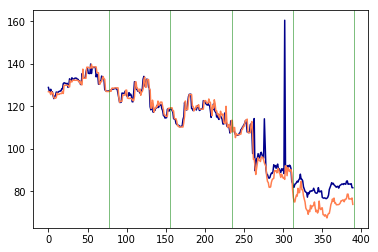

In [324]:
# code for plotting the predictions against the expected over "time"
preds = rf_next_close.predict(X_valid_close)
x = [i for i in range(len(preds))]
plt.plot(x,preds, color='darkblue')
plt.plot(x, y_valid_close, color='coral')
for i in range(1, 6):
    plt.axvline(x=78*i, color='green', linewidth=0.5)
plt.show()